In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
import dill
from tqdm import tqdm 
from scipy.signal import find_peaks
import sys
'''

'''

c:\Users\Seth Sullivan\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Seth Sullivan\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Seth Sullivan\anaconda3\lib\site-packages\numpy\.libs\libopenblas.fb5ae2tyxyh2ijrdkgdgq3xbklktf43h.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


'\n\n'

In [2]:
sys.path.insert(0,'D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement')
import filter_functions as ff
                

In [3]:
# Fields pull and pull list
os.chdir('D:\OneDrive - University of Delaware - o365\Subject_Data\MatchPennies_Agent_Exp2')
PATH = os.getcwd()

analysis_pull_list = []
with open("Analysis_Pull_List.txt", "r") as file:
    analysis_pull_list = file.read().splitlines()
analysis_pull_list_reaction = [s+'_Reaction' for s in analysis_pull_list]
analysis_pull_list_timing = [s+'_Timing' for s in analysis_pull_list]
analysis_pull_list_task = [s+'_Task' for s in analysis_pull_list]
# with open("\\Analysis_Pull_List_Control.txt", "r") as pull_file:
#     analysis_pull_list_control = pull_file.read().splitlines()
# with open("\\Analysis_Pull_List_Task.txt", "r") as pull_file:
#     analysis_pull_list_task = pull_file.read().splitlines()
with open("Fields_Pull.txt", "r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()
    
num_subjects = len(analysis_pull_list)
task_name = 'Matchpennies_Agent_Exp2'

Target information

- Row 0 = Start Target

- Row 1 = Left screen, right target x pos (left target is 2*startx - right targetx)

- Dim 1 = Radius

- Dim 2 = Thickness of the circle edge (don't know if this matters)


Dataframe is in centimeters, so need to divide everything by 100

In [4]:
file = 'Sub1_Reaction\\Sub1_ReactionTarget_Table.csv'
df = pd.read_csv(file)
df["X"] = df["X"]/100
df["Y"] = df["Y"]/100
df['Dim 1'] = df['Dim 1']/100 # Target table is in centimeters, I guess this doesn't matter but it makes me feel better
df['Dim 2'] = df['Dim 2']/100
# Target information for Right Hand (keeping this because the positions of target 3 and 4 are based on target 1 and start 1)
startx = df.loc[0]['X']
starty = df.loc[0]['Y']
start_radius = df.loc[0]['Dim 1'] 

target1x = df.loc[1]['X']
target1y = df.loc[1]['Y']
target1_radius = df.loc[1]['Dim 1']

target2x = 2*startx - target1x
target2y = target1y
target2_radius = target1_radius

# Timing target
timing_targetx = startx
timing_targety = target1y
timing_target_pos = np.sqrt(timing_targetx**2 + timing_targety**2)
timing_target_radius = target1_radius   

# Parse Reaction Task Data

In [19]:
#%% Get reaction time data
block_table = pd.read_csv(f'Sub1_Reaction\\Sub1_ReactionBlock_Table.csv')
num_trials = block_table['List_Reps'].loc[0]
num_blocks = sum(~block_table['TP_LIST'].isna())
trial_time = 2000
tot_trials = int(sum(block_table['List_Reps']))

filenames = np.empty((num_subjects, num_blocks,num_trials),dtype = object)
trial_start = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
agent_reaction_decision_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
agent_reaction_decision_array = np.empty((num_subjects, num_blocks,num_trials))*np.nan

player_reaction_decision_array = np.empty((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_decision_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_movement_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_plus_movement_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_reach_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_time_vel = np.zeros((num_subjects, num_blocks,num_trials))*np.nan

trial_type_array = np.zeros((num_subjects, num_blocks,num_trials))*np.nan

data = np.zeros((num_subjects, num_blocks,num_trials, trial_time, 2))*np.nan

###-------------------------------------------------------------------------------------------------------
for i in range(1):
    subname = analysis_pull_list_reaction[i]
    print(i, subname)
    trial_table = pd.read_csv(subname+f'\\{subname}Trial_Table.csv')
    for x in ((range(tot_trials))):
        block_number = trial_table.iloc[x]['Block_Row']
        tp_num = trial_table.iloc[x]['TP_Row']
        block_trial_num = trial_table.iloc[x]['Block_Step']
        filename = f"{subname}\\{task_name}_{subname}_C{block_number}_TP{tp_num}_T{block_trial_num}.csv"
        j = tp_num - 1 # Block number
        k = block_trial_num - 1 # Trial number in that block
        filenames[i,j,k] = filename
        data = pd.read_csv(filename, low_memory=False)
        event_code_col = data['Event_Codes']
        # if 'E_REDO_TRIAL' in event_code_col.unique():
        #     data_start = data.index[data['Event_Codes']=='E_REDO_TRIAL']
        #     data = data.iloc[data_start[-1]:]
        if 'E_GO_TRIAL' in event_code_col.unique():
            start_time = int(data[data['Event_Codes']=='E_GO_TRIAL'].index[-1])
            trial_type_array[i,j,k] = 1
        elif 'E_SHUTOFF_TRIAL' in event_code_col.unique():
            start_time = int(data[data['Event_Codes']=='E_SHUTOFF_TRIAL'].index[-1])
            trial_type_array[i,j,k] = 0
        else:
            raise Exception('ERROR, event code not found')
            
        # Get Reaction Time Data
        end_time = start_time + trial_time
        trial_start[i,j,k] = start_time
        agent_reaction_decision_time[i,j,k] = data.iloc[start_time]['Agent_Decision_Time']
        
        lhx = data.iloc[start_time:end_time]['Left_HandX'].to_numpy()
        lhy = data.iloc[start_time:end_time]['Left_HandY'].to_numpy()
        lhx_vel = data.iloc[start_time:end_time]['Left_HandXVel'].to_numpy()
        lhy_vel = data.iloc[start_time:end_time]['Left_HandYVel'].to_numpy()
        lhx_vel = ff.Filter_KIN(data.iloc[start_time:end_time]['Left_HandXVel'].to_numpy())
        lhy_vel = ff.Filter_KIN(data.iloc[start_time:end_time]['Left_HandYVel'].to_numpy())

        q = np.argwhere(np.sqrt((lhx-target1x)**2 + (lhy-target1y)**2) < target1_radius)
        r = np.argwhere(np.sqrt((lhx-target2x)**2 + (lhy-target2y)**2) < target2_radius) 
        s = np.argwhere(np.sqrt((lhx-startx)**2 + (lhy-starty)**2) > start_radius*1) # Multiplied by 1.2 so people don't accidentally drift outside start
        
        t = np.argwhere(np.sqrt((lhx_vel)**2 + (lhy_vel)**2) > 0.05)
        speed = np.sqrt((lhx_vel)**2 + (lhy_vel)**2)
        

        if np.size(t)>0:
            player_reaction_time_vel[i,j,k] = t[0] - agent_reaction_decision_time[i,j,k]

        if np.size(s)>0: 
            player_reaction_decision_time[i,j,k] = s[0]
            player_reaction_time[i,j,k] = s[0]  - agent_reaction_decision_time[i,j,k]
        if np.size(q)>0: #if LH enters right target
            player_reaction_decision_array[i,j,k] = 1
            player_reaction_movement_time[i,j,k] = q[0] - s[0]
            player_reaction_plus_movement_time[i,j,k] = q[0] - agent_reaction_decision_time[i,j,k]
            
        elif np.size(r)>0: #if LH enters left target
            player_reaction_decision_array[i,j,k] = -1   
            player_reaction_movement_time[i,j,k] = r[0] - s[0]
            player_reaction_plus_movement_time[i,j,k] = r[0] - agent_reaction_decision_time[i,j,k]          
            
        # #plot path for Reactions
        if False:
            for i in range(1):
                plot_end_time = int(agent_reaction_decision_time[i,j,k] + player_reaction_time[i,j,k])
                # plot_end_time = int(start_time + 500)
                lhx_new = np.array(data.iloc[start_time:int(start_time+s[0][0])]['Left_HandX'])
                lhy_new = np.array(data.iloc[start_time:int(start_time+s[0][0])]['Left_HandY'])
                plt.figure(dpi=300)
                circleR = plt.Circle((target1x,target1y), target1_radius, color = 'r', fill = False)
                circleL = plt.Circle((target2x,target2y), target2_radius, color = 'r', fill = False)
                startCirc = plt.Circle((startx,starty), start_radius, color = 'r', fill = False)
                fig, ax = plt.subplots()
                ax.add_patch(circleR)
                ax.add_patch(circleL)
                ax.add_patch(startCirc)
                plt.plot(lhx_new,lhy_new) 
                # plt.scatter(lhx_new[int(s[0])], lhy_new[int(s[0])])
                # print(player_reaction_time[i,j,k])
                # plt.title("w =%1.0f " %i + "x=%1.0f "%j + "c=%1.0f"%k + 'vely=%1.5f'%vel_check)
                plt.figure()
                print(speed)
                plt.plot(speed)
                plt.show()
shutoff_mask = trial_type_array == 0
go_mask = trial_type_array == 1
player_shutoff_reaction_time = player_reaction_time*shutoff_mask     
player_shutoff_reaction_time[~shutoff_mask] = np.nan      
player_go_reaction_time = player_reaction_time*go_mask          
player_go_reaction_time[~go_mask] = np.nan      
 

0 Sub4_Reaction


In [20]:
player_reaction_time_vel

array([[[ 946.62176514,  270.42407227,  396.11334229,  780.96832275,
                   nan,  300.61132812,  341.52972412,  469.14874268,
          219.003479  ,  284.60473633,  401.19250488,  377.03326416,
          322.84429932,  374.75274658,  315.65234375,  263.62438965,
          416.95233154,  284.26867676,  261.22650146,  301.32012939,
          258.24450684,  299.76660156,  294.84863281,  278.46972656,
          345.71203613,  225.49688721,  119.7769165 ,  265.56884766,
          270.96478271,  289.00256348,  249.50048828,  290.49487305,
          316.04199219,  340.15606689,  357.51708984,  203.92248535,
          457.65264893,  255.07244873,  360.82965088,  302.29925537,
          191.15606689,  185.99285889,  265.35217285,   97.581604  ,
          226.18664551,  276.6282959 ,  219.52832031,  403.10656738,
          169.93658447,  145.65093994,  392.18157959,  346.89331055,
          253.22558594,  260.43762207,  348.02160645,  239.15264893,
          288.2321167 ,  465.61608

In [8]:
nanmask1 = np.isnan(player_go_reaction_time)
reaction_time_react_switch = np.nanmedian(player_go_reaction_time[0,0,:][~nanmask1[0,0,:]])
reaction_time_react = np.nanmedian(player_go_reaction_time[0,1,:][~nanmask1[0,1,:]])

nanmask2 = np.isnan(player_shutoff_reaction_time)
reaction_time_gamble_switch = np.nanmedian(player_shutoff_reaction_time[0,0,:][~nanmask2[0,0,:]])
reaction_time_gamble = np.nanmedian(player_shutoff_reaction_time[0,2,:][~nanmask2[0,2,:]])

# Pickle Reaction Stuff

In [9]:
i=-1
for subname in analysis_pull_list:
    i+=1
    data_path = f'Subjects_Analyzed\\{subname}\\'
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    print(subname)
    print(data_path)
    dill.dump(player_reaction_time[i,:,:], open(data_path + f'{subname}_player_reaction_time.pkl', 'wb'))
    dill.dump(player_reaction_movement_time[i,:,:], open(data_path + f'{subname}_player_reaction_movement_time.pkl', 'wb'))
    dill.dump(player_reaction_plus_movement_time[i,:,:], open(data_path + f'{subname}_player_reaction_plus_movement_time.pkl', 'wb'))
    dill.dump(player_reaction_decision_array[i,:,:], open(data_path + f'{subname}_player_reaction_decision_array.pkl', 'wb'))
    dill.dump(agent_reaction_decision_array[i,:,:], open(data_path + f'{subname}_agent_reaction_decision_array.pkl', 'wb'))
    dill.dump(agent_reaction_decision_time[i,:,:], open(data_path + f'{subname}_agent_reaction_decision_time.pkl', 'wb'))
    dill.dump(trial_type_array[i,:,:], open(data_path + f'{subname}_reaction_trial_type_array.pkl', 'wb'))
    
    # dill.dump(agent_decision_time[i,:], open(data_path + f'{subname}_agent_decision_time.pkl', 'wb'))


Sub4
Subjects_Analyzed\Sub4\
Sub5
Subjects_Analyzed\Sub5\


# Parse Timing Data

In [10]:
coincidence_trial_time = 2500
coincidence_trials = 50
coincidence_trial_start = np.zeros((num_subjects, coincidence_trials))*np.nan
coincidence_reach_time = np.zeros((num_subjects, coincidence_trials))*np.nan

interval_trial_time = 2500
interval_trials = 50
interval_trial_start = np.zeros((num_subjects, interval_trials))*np.nan
interval_reach_time =  np.zeros((num_subjects, interval_trials))*np.nan

control_trials = interval_trials + coincidence_trials
###-------------------------------------------------------------------------------------------------------
for i in range(num_subjects):
    sub_name = analysis_pull_list_timing[i]
    print(i, sub_name)
    file = f'{sub_name}\\{sub_name}Trial_Table.csv'
    control_trial_table = pd.read_csv(file)
    block_number = 1
    tp_num = 1
    for x in ((range(control_trials))):
        block_number = control_trial_table.iloc[x]['Block_Row']
        tp_num = control_trial_table.iloc[x]['TP_Row']
        block_trial_num = control_trial_table.iloc[x]['Block_Step']
        filename = f'{sub_name}\\{task_name}_{sub_name}_C{block_number}_TP{tp_num}_T{block_trial_num}.csv'
        j = tp_num - 1 # Block number
        k = block_trial_num - 1 # Trial number in that block
        data = pd.read_csv(filename, low_memory=False)
        # if 'Agent_Initial_Time' in data.columns:
        #     data = data.rename(columns = {'Agent_Inital_Time':'Agent_Decision_Time'}, inplace=True)
        # f = data['Agent_Decision_Time']
        start_time = int(data[data['Event_Codes']=='E_SOUND_SIGNAL'].index[0])
        # Get Interval Timing Data
        if tp_num == 1:
            end_time = start_time + interval_trial_time
            interval_trial_start[i,k] = start_time # Store start time
            lhx = np.array(data.iloc[start_time:end_time]['Left_HandX'])
            lhy = np.array(data.iloc[start_time:end_time]['Left_HandY'])
            q = np.argwhere(np.sqrt((lhx-timing_targetx)**2 + (lhy-timing_targety)**2) < timing_target_radius) # THIS NEEDS TO BE THE CENTER TARGET... x poisition should be the start
            if np.size(q)>0:
                interval_reach_time[i,k] = q[0]
        # Get Coincidence Timing Data
        if tp_num == 2:
            end_time = start_time + coincidence_trial_time
            coincidence_trial_start[i,k] = start_time # Store start time
            lhx = np.array(data.iloc[start_time:end_time]['Left_HandX'])
            lhy = np.array(data.iloc[start_time:end_time]['Left_HandY'])
            q = np.argwhere(np.sqrt((lhx-timing_targetx)**2 + (lhy-timing_targety)**2) < timing_target_radius) # THIS NEEDS TO BE THE CENTER TARGET... x poisition should be the start
            if np.size(q)>0:
                coincidence_reach_time[i,k] = q[0] 
                
            # #plot path for Reactions
            if False:
                for i in range(1):
                    player_reaction_time[0,0] = 500
                    plot_end_time = int(start_time + player_reaction_time[i,k])
                    # plot_end_time = int(start_time + 500)
                    lhx_new = np.array(data.iloc[start_time:int(plot_end_time)]['Left_HandX'])
                    lhy_new = np.array(data.iloc[start_time:int(plot_end_time)]['Left_HandY'])
                    plt.figure(dpi=300)
                    circleR = plt.Circle((target1x,target1y), target1_radius, color = 'r', fill = False)
                    circleL = plt.Circle((target2x,target2y), target2_radius, color = 'r', fill = False)
                    startCirc = plt.Circle((startx,starty), start_radius, color = 'r', fill = False)
                    fig, ax = plt.subplots()
                    ax.add_patch(circleR)
                    ax.add_patch(circleL)
                    ax.add_patch(startCirc)
                    plt.plot(lhx_new,lhy_new) 
                    # plt.scatter(lhx_new[int(s[0])], lhy_new[int(s[0])])
                    print(player_reaction_time[i,k])
                    # plt.title("w =%1.0f " %i + "x=%1.0f "%j + "c=%1.0f"%k + 'vely=%1.5f'%vel_check)
                    plt.show()

0 Sub4_Timing
1 Sub5_Timing


# Pickle Timing Data

In [11]:
i=-1
for subname in analysis_pull_list:
    i+=1
    data_path = f'Subjects_Analyzed\\{subname}\\'
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    print(subname)
    print(data_path)
    dill.dump(interval_trial_start[i,:], open(data_path + f'{subname}_interval_trial_start.pkl', 'wb'))
    dill.dump(interval_reach_time[i,:], open(data_path + f'{subname}_interval_reach_time.pkl', 'wb'))
    dill.dump(coincidence_trial_start[i,:], open(data_path + f'{subname}_coincidence_trial_start.pkl', 'wb'))
    dill.dump(coincidence_reach_time[i,:], open(data_path + f'{subname}_coincidence_reach_time.pkl', 'wb'))

Sub4
Subjects_Analyzed\Sub4\
Sub5
Subjects_Analyzed\Sub5\


# Parse Task Data

In [12]:
#%% Get task time task_df
# Get trials, blocks, trial_time from trial_table
path1 = PATH+'\\'+'Sub1_Task'
task_df = pd.read_csv(path1+f'\\Sub1_TaskTrial_Table.csv')
task_df = task_df.loc[task_df['Condition type']==3] # Only get the task condition 
num_trials = int(task_df.iloc[-1]['Block_Step']) # number of trials in each block
num_blocks = int(task_df.iloc[-1]['Block_Row'])
tot_trials = int(num_trials*num_blocks)
trial_time = int(task_df.iloc[0]['Condition time'])
task_df_columns = len(fields_pull)
# Need to be kept outside subject for-loop
task_trial_end = np.zeros([num_subjects, num_blocks, num_trials, 2])*np.nan
task_trial_start = np.zeros((num_subjects, num_blocks, num_trials))*np.nan
filename_storage = np.empty((num_subjects, num_blocks, num_trials), dtype=object)

task_data = np.zeros((num_subjects, num_blocks, num_trials, trial_time+500, task_df_columns))*np.nan
win_check_R = np.zeros((num_subjects, num_blocks))
win_check_L = np.zeros((num_subjects, num_blocks))
num_miss_check_R = np.zeros((num_subjects, num_blocks))
num_miss_check_L = np.zeros((num_subjects, num_blocks))
#########
player_task_decision_array = np.empty((num_subjects, num_blocks, num_trials))
player_task_reach_time = np.zeros([num_subjects, num_blocks, num_trials])*np.nan
player_task_decision_time = np.zeros([num_subjects, num_blocks, num_trials])*np.nan
player_task_movement_time = np.zeros([num_subjects, num_blocks, num_trials])*np.nan
agent_task_decision_time = np.zeros((num_subjects, num_blocks, num_trials))
agent_task_reach_time = np.zeros((num_subjects, num_blocks, num_trials))
agent_task_decision_array = np.zeros((num_subjects, num_blocks, num_trials))

###-------------------------------------------------------------------------------------------------------
for i in range(num_subjects):
    sub_name = analysis_pull_list_task[i]
    print(i, sub_name)
    path1 = PATH+'\\'+sub_name
    file = path1+f'\\{sub_name}Trial_Table.csv'
    trial_table = pd.read_csv(file)
    # Splt trial table into task and washout based on condition type
    task_trial_table = trial_table[trial_table['Condition type']==3]
    block_number = 1
    tp_num = 1
    for x in tqdm((range(tot_trials))):
        block_number = task_trial_table.iloc[x]['Block_Row']
        tp_num = task_trial_table.iloc[x]['TP_Row']
        block_trial_num = task_trial_table.iloc[x]['Block_Step']
        j = tp_num - task_trial_table['TP_Row'].min()  # Block number
        k = block_trial_num - 1 # Trial number in that block
        
        filename = PATH+f"\\{sub_name}\\{task_name}_{sub_name}_C{block_number}_TP{tp_num}_T{block_trial_num}.csv"
        task_df = pd.read_csv(filename, low_memory=False)
        start_time = int(task_df[task_df['Event_Codes']=='E_SOUND_SIGNAL'].index[0])
        end_time = start_time + trial_time + 500 # Add 500 to see when they got there when trial ended
        data_task_df = task_df.drop(columns ='Event_Codes') # Drop event codes cuz it's not number column and can't be an array 
        task_data[i,j,k,:,:] = np.array(data_task_df.iloc[start_time:end_time])

        task_trial_start[i,j,k] = start_time
        lhx = np.array(task_df.iloc[start_time:end_time]['Left_HandX'])
        lhy = np.array(task_df.iloc[start_time:end_time]['Left_HandY'])
        q = np.argwhere(np.sqrt((lhx-target1x)**2 + (lhy-target1y)**2) < target1_radius)
        r = np.argwhere(np.sqrt((lhx-target2x)**2 + (lhy-target2y)**2) < target2_radius) 
        s = np.argwhere(np.sqrt((lhx-startx)**2 + (lhy-starty)**2) > start_radius*1.2) # Multiplied by 2 so people don't accidentally drift outside start
        
        #print(vel_check)
        agent_task_decision_time[i,j,k] = task_df.iloc[start_time+1]['Agent_Decision_Time'] 
        agent_task_reach_time[i,j,k] = agent_task_decision_time[i,j,k] + 150  
        agent_task_decision_array[i,j,k] = task_df.iloc[start_time+1]['Agent_Target_Selection']
        if np.size(s)>0: 
            vel_check = task_df.iloc[s[0]]['Left_HandYVel']
            player_task_decision_time[i,j,k] = s[0]
            
        if np.size(q)>0: #if LH enters right target
            player_task_decision_array[i,j,k] = 1
            player_task_movement_time[i,j,k] = q[0] - s[0]
            player_task_reach_time[i,j,k] = q[0]
        elif np.size(r)>0: #if LH enters left target
            player_task_decision_array[i,j,k] = -1   
            player_task_movement_time[i,j,k] = r[0] - s[0]
            player_task_reach_time[i,j,k] = r[0]
        if player_task_reach_time[i,j,k] > 1500 or np.isnan(player_task_reach_time[i,j,k]):
            player_task_decision_array[i,j,k] = 0
        if agent_task_reach_time[i,j,k]>1500:
            agent_task_decision_array[i,j,k] = 0    
        #plot path for tasks
        if False:
            for i in range(1):
                plot_end_time = int(start_time + player_task_reach_time[i,j,k])
                lhx_new = np.array(task_df.iloc[start_time:int(plot_end_time)]['Left_HandX'])
                lhy_new = np.array(task_df.iloc[start_time:int(plot_end_time)]['Left_HandY'])
                plt.figure(dpi=300)
                circleR = plt.Circle((target1x,target1y), target1_radius, color = 'r', fill = False)
                circleL = plt.Circle((target2x,target2y), target2_radius, color = 'r', fill = False)
                startCirc = plt.Circle((startx,starty), start_radius, color = 'r', fill = False)
                fig, ax = plt.subplots()
                ax.add_patch(circleR)
                ax.add_patch(circleL)
                ax.add_patch(startCirc)
                plt.plot(lhx_new,lhy_new) 
                plt.scatter(lhx_new[int(s[0])], lhy_new[int(s[0])])

                plt.title("w =%1.0f " %i + "x=%1.0f "%j + "c=%1.0f"%k + 'vely=%1.5f'%vel_check)
                plt.show()
    print(player_task_decision_time[i,0,:])
           

0 Sub4_Task


100%|██████████| 320/320 [00:05<00:00, 55.56it/s]


[1392. 1364. 1270. 1353. 1310. 1385. 1336. 1258. 1355. 1281. 1337. 1391.
 1400. 1342. 1334. 1351. 1403. 1383. 1357. 1452. 1330. 1134. 1390. 1241.
 1394. 1378. 1132. 1332. 1197. 1385. 1424. 1334. 1387. 1253. 1259. 1295.
 1339. 1212. 1298. 1374. 1350. 1371. 1377. 1343. 1375. 1282. 1415. 1436.
 1442. 1247. 1306. 1299. 1333. 1394. 1385. 1335. 1410. 1316. 1358. 1413.
 1419. 1367. 1417. 1376. 1397. 1412. 1366. 1384. 1449. 1503. 1363. 1376.
 1364. 1252. 1301. 1414. 1418. 1330. 1430. 1369.]
1 Sub5_Task


100%|██████████| 320/320 [00:05<00:00, 59.00it/s]

[1320. 1523. 1301. 1018.  704. 1481. 1195. 1431. 1340. 1025. 1200. 1191.
 1070. 1412.  919. 1353. 1443. 1386. 1309. 1209. 1205. 1399. 1344. 1458.
 1419. 1342.  935.  724. 1054. 1348. 1096.  735. 1159. 1135. 1187. 1365.
 1285. 1432. 1099. 1307.  991. 1363. 1215.  845.  944.  964.  851.  877.
  815. 1390. 1328. 1380. 1240. 1396. 1114. 1169. 1260. 1202. 1128. 1099.
 1033. 1188. 1152. 1172. 1243. 1299. 1108. 1240. 1273. 1288. 1397. 1011.
 1086.  865. 1048. 1167. 1043.  970. 1116. 1162.]


# Pickle Task Data

In [13]:
i=-1
for subname in analysis_pull_list:
    i+=1
    data_path = PATH+f'\\Subjects_Analyzed\\{subname}\\'
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    print(subname)
    dill.dump(task_data[i,:,:,:,:], open(data_path + f'{subname}_task_data.pkl', 'wb'))
    dill.dump(player_task_decision_time[i,:,:], open(data_path + f'{subname}_player_task_decision_time.pkl', 'wb'))
    dill.dump(player_task_decision_array[i,:,:], open(data_path + f'{subname}_player_task_decision_array.pkl', 'wb'))
    dill.dump(player_task_movement_time[i,:,:], open(data_path + f'{subname}_player_task_movement_time.pkl', 'wb'))
    dill.dump(player_task_reach_time[i,:,:], open(data_path + f'{subname}_player_task_reach_time.pkl', 'wb'))
    dill.dump(agent_task_decision_time[i,:,:], open(data_path + f'{subname}_agent_task_decision_time.pkl', 'wb'))
    dill.dump(agent_task_decision_array[i,:,:], open(data_path + f'{subname}_agent_task_decision_array.pkl', 'wb'))
    dill.dump(agent_task_reach_time[i,:,:], open(data_path + f'{subname}_agent_task_reach_time.pkl', 'wb'))

Sub4
Sub5


In [14]:
arr1 = data[start_time:end_time]['Left_HandXVel'].to_numpy()
arr2 = data[start_time:end_time]['Left_HandYVel'].to_numpy()
arr = np.sqrt(arr1**2 + arr2**2)
mask = np.isnan(arr)

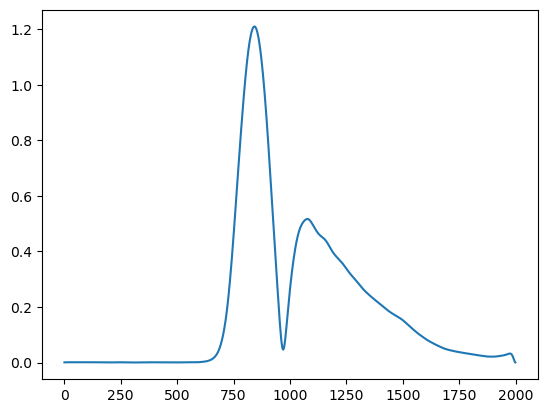

In [15]:
filtered_velocity = ff.Filter_KIN(arr[~mask])
plt.plot(filtered_velocity)
# plt.plot(arr)

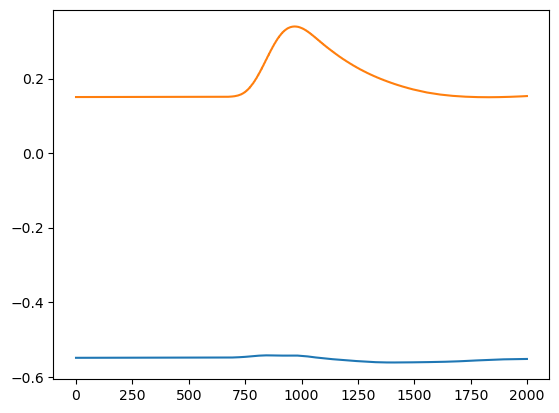

In [16]:
arr1 = data[start_time:end_time]['Left_HandX'].to_numpy()
arr2 = data[start_time:end_time]['Left_HandY'].to_numpy()
arr = np.sqrt(arr1**2 + arr2**2)
plt.plot(arr1) 
plt.plot(arr2)
# plt.ylim(0.568,0.58)